In [28]:
println(VERSION, " (", Sys.CPU_NAME, ")")

1.7.0 (cyclone)


In [29]:
# + units and constants
using Unitful
↦(value::Unitful.Units, unit::Unitful.Units) = Unitful.convfact(unit, value)
↦(value::Unitful.Quantity, unit::Unitful.Units) = uconvert(unit, value).val

# units
const °C = u"°C"
const K  = u"K"  ↦ u"K"
const kB = u"k"  ↦ u"J/K"
const C  = u"C"  ↦ u"C"
const V  = u"V"  ↦ u"V"
const m  = u"m"  ↦ u"m"
const cm = u"cm" ↦ u"m"
const u  = u"u"  ↦ u"kg"
const s  = u"s"  ↦ u"s"
const ms = u"ms" ↦ u"s"
const ns = u"ns" ↦ u"s"
const ps = u"ps" ↦ u"s"
const μs = u"μs" ↦ u"s"
const A  = u"A"  ↦ u"A"
const kA = u"kA" ↦ u"A"
const kV = u"kV" ↦ u"V"
const MV = u"MV" ↦ u"V"
const eV = u"eV" ↦ u"eV"
const kg = u"kg" ↦ u"kg"
const mps = u"m/s" ↦ u"m/s"
const kmps = u"km/s" ↦ u"m/s"
const kHz = u"kHz" ↦ u"Hz"
const MHz = u"MHz" ↦ u"Hz"
const GHz = u"GHz" ↦ u"Hz"

# constants
const ɛ0 = u"ɛ0" ↦ u"F/m"
const c0 = sqrt(u"1/ɛ0" * u"1/μ0") ↦ u"m/s"
const qe = 1.602_176_6208e-19C  # elementary charge
const me = 9.109_383_7015e-31kg # mass of electron
const mp = 1.672_621_8982e-27kg # mass of proton
nothing

In [30]:
function thermal_speed(T, m)
  sqrt(2kB*T/m)
end

function beam_speed(U, qm)
  sqrt(U * 2.0 * qm) 
end

beam_speed (generic function with 1 method)

In [31]:
using StaticArrays
using LinearAlgebra
using Statistics
using SparseArrays
using ACME

include("ParticleInCell/src/pic/kinetic.jl")
include("ParticleInCell/src/pic/sources.jl")

include("pole/boundary_conditions.jl")
include("pole/gradient.jl")
include("pole/iterative_methods.jl")
include("pole/inplace_periodic_solver.jl")
include("pole/linear_solver.jl")
include("pole/linear_solver1.jl")

include("RegularGrids/src/uniform_grid.jl")
include("ParticleInCell/src/pic/pushers.jl")

push_in_cartesian! (generic function with 1 method)

In [32]:
const CavityCircuitModel = ACME.DiscreteModel{Tuple{}}

DiscreteModel{Tuple{}}

In [33]:
include("ParticleInCell/src/pic/state.jl")
import Random: Xoshiro
struct KlystronProblem
    I0 :: Float64 # Beam current
    U0 :: Float64 # Beam voltage
    I1 :: Float64 # External current amplitude
    
    rng :: Xoshiro # random number generator
    
    beam :: MaxwellianSource{1, 3}
    grid :: UniformGrid{:xy, 1}
    solver :: LinearSolver{1, Tuple{DirichletBC, DirichletBC}}
    pusher :: BorisPusher{:xy}
    
    frequency :: Float64
    timesteps :: Int64
    # field data
    ne :: Vector{Float64}
    rho:: Matrix{Float64}
    Ex :: Matrix{Float64}
    Jx :: Matrix{Float64}
    # circuit models of cavities
    cavity1 :: CavityCircuitModel
    cavity2 :: CavityCircuitModel
    cavity1def :: UnitRange{Int64}
    cavity2def :: UnitRange{Int64}
    # V/I in the cavities
    v_ext :: Vector{Float64}
    i_ext :: Vector{Float64}
    v_ind :: Vector{Float64}
    i_ind :: Vector{Float64}
end

In [34]:
solution(ps::LinearSolver) = reshape(ps.u, ps.n...)
gradient(ps::LinearSolver) = GradientOperator(ps.n[1], ps.δ[1], ps.bcs)

function create_poisson_solver(grid)
    xf, = grid.facets
    ps = LinearSolver(xf)
end

function calculate_electric_potential(ps, f)
    @inbounds for i in eachindex(f)
      f[i] /= ε0
    end
    solve!(ps, f)
    φ  = solution(ps)
    φ.-= mean(φ)
end

calculate_electric_potential (generic function with 1 method)

In [35]:
using Random; Random.seed!(0)

function build(I0, U0, I1; quiet=true)
    # + spatial and temporal paramters
    ts = 10_000
    nx = 73

    νtherm = thermal_speed(300K, me)
    νdrift = beam_speed(U0, qe/me)

    Lx = 0.372m
    Δx = Lx / nx
    Δt = 5.0ps
    electronNumRatio = 3e10
    simulationVolume = nx * Δx
    numCells         = nx
    
    if quiet == false
        println("Δt: ", Δt, "\nΔx: ", Δx, "\nLx: ", Lx)
        println("νtherm: ", round(νtherm/c0; sigdigits=1), "c")
        println("νdrift: ", round(νdrift/c0; sigdigits=3), "c")
        println("I0: ", 1e-3I0, "kA U0: ", round(1e-3U0; sigdigits=5), "kV")
        println("I1: ", I1, "A")
        println("real particles per macroparticle: ", electronNumRatio)
    end
    
    # + species and sources
    e   = KineticSpecies{1,3}(:e,  200_000, -1qe, 1me,  electronNumRatio)
    beam = MaxwellianSource{1,3}(I0 / 1qe / electronNumRatio, [2Δx], [0.,0.,0.], dv=[+νdrift,0.,0.])
    species = [e]
    
    xf = 0m:Δx:Lx
    grid = create_uniform_grid(xf)
    solver = create_poisson_solver(grid)
    pusher = create_boris_pusher(species)
        
    φ = zeros(Float64, nx)
    ρ = zeros(Float64, nx)
    J = zeros(Float64, nx + 1)
    E = zeros(SVector{3, Float64}, nx + 1)
    B = zeros(SVector{3, Float64}, nx + 1)
    initial = ParticleInCellState(tuple(e), φ, E, B, ρ, J, Δt, Δx)
    
    ne = zeros(ts)
    rho= zeros(nx, ts)
    Ex = zeros(nx + 1, ts)
    Jx = zeros(nx + 1, ts)
    
    freq = 1.21GHz
    buncher = let
        ω0 = 2π * freq
        RoverQ = 100.0
        L = RoverQ / ω0
        C = (1.0 / RoverQ) * (1.0 / ω0)
        Q = 1.0 / (1.0 / 2300.0 + 1.0 / 20.0)
        R = RoverQ * Q

        cavity = @circuit begin
            u = voltageprobe()
            i = currentsource() # induced current
            j = currentsource() # external current
            r = resistor(R)
            c = capacitor(C)
            l = inductor(L)
            i[+] == j[+] == r[1] == l[1] == c[1]
            i[-] == j[-] == r[2] == l[2] == c[2]
            i[+] == j[+] == u[+]
            i[-] == j[-] == u[-] == gnd
        end
        model = DiscreteModel(cavity, Δt)
    end
    
    catcher = let
        ω0 = 2π * freq
        RoverQ = 100.0
        L = RoverQ / ω0
        C = (1.0 / RoverQ) * (1.0 / ω0)
        Q = 1.0 / (1.0 / 47.124) 
        R = RoverQ * Q

        cavity = @circuit begin
            u = voltageprobe()
            i = currentsource() # induced current
            j = currentsource() # external current
            r = resistor(R)
            c = capacitor(C)
            l = inductor(L)
            i[+] == j[+] == r[1] == l[1] == c[1]
            i[-] == j[-] == r[2] == l[2] == c[2]
            i[+] == j[+] == u[+]
            i[-] == j[-] == u[-] == gnd
        end
        model = DiscreteModel(cavity, Δt)
    end

    v_ind = zeros(ts)
    i_ind = zeros(ts)
    v_ext = zeros(ts)
    i_ext = zeros(ts)
    context = KlystronProblem(I0, U0, I1, Xoshiro(0x00), beam, grid, solver, pusher,
        freq, ts, ne, rho, Ex, Jx,
        buncher, catcher, 19:24, 50:55,
        v_ext, i_ext, v_ind, i_ind)
    return initial, context
end

build (generic function with 1 method)

In [36]:
using FFTW
function evaluate(results; quiet=true)
    Δt = 5.0e-12
    window = 5_000:10_000
    samples = length(window)
    frequencies = fftfreq(samples, 1.0 / Δt)
    
    i2 = results.i_ind[window]
    v2 = results.v_ind[window]
    I2 = fft(i2 .- mean(i2))
    V2 = fft(v2 .- mean(v2))
    
    I2 ./= samples
    I2 .*= 2.0
    V2 ./= samples
    V2 .*= 2.0

    Pmax = 0.0
    for k=1:samples
        Pk = abs(I2[k] * conj(V2[k]))
        if Pk > Pmax
            Pmax = Pk
        end
    end
    
    if quiet == false
        println("Output power is ", round(1e-6Pmax, digits=3), " MW")
    end
    
    return Pmax
end

evaluate (generic function with 1 method)

In [37]:
include("ParticleInCell/src/pic/wrap.jl")
@inline function enter_loop(context :: KlystronProblem, state)
    e, = state.particles
    e.np = 0
    copy!(Random.GLOBAL_RNG, context.rng)
    
    #GR.inline("mov")
    #GR.setmarkersize(0.7)
    
    return nothing
end

@inline function after_solver(context :: KlystronProblem, state, i)
    t = i * state.timestep
    i_ext = context.I1 * sin(2π * context.frequency * t)
    i_ind = 0.0
    
    buncher = context.cavity1
    catcher = context.cavity2
    
    for j = context.cavity2def i_ind += state.cellsize * state.current[j] end
    
    v_ext = first(ACME.run!(buncher, @SMatrix [0.0; i_ext]))
    v_ind = first(ACME.run!(catcher, @SMatrix [i_ind; 0.0]))
    e_ext = - v_ext / state.cellsize / length(context.cavity1def)
    e_ind = - v_ind / state.cellsize / length(context.cavity2def)
    
    for j = context.cavity1def state.electric[j] += @SVector [e_ext, 0.0, 0.0] end
    for j = context.cavity2def state.electric[j] += @SVector [e_ind, 0.0, 0.0] end
    
    context.v_ind[i] = v_ind
    context.i_ind[i] = i_ind
    context.v_ext[i] = v_ext
    context.i_ext[i] = i_ext
    
    return nothing
end

@inline function after_pusher(context :: KlystronProblem, state, i)
    for part in state.particles
        discard!(part, context.grid, 1)
    end
    
    e, = state.particles
    
    return nothing
end

@inline function after_loop(context :: KlystronProblem, state, i)
    e, = state.particles
    mx, = context.grid.n
    context.ne[i] = e.np
    for j=1:mx context.Ex[j,i] = state.electric[j][1] end
    for j=1:mx context.Jx[j,i] = state.current[j] end
    for j=1:mx-1 context.rho[j,i] = state.density[j] end
    
    sample!(context.beam, e, state.timestep)
    return nothing
end

@inline function exit_loop(context :: KlystronProblem, state)
    copy!(context.rng, Random.GLOBAL_RNG)
    return nothing
end

exit_loop (generic function with 1 method)

In [41]:
struct FluidSpecies end
include("ParticleInCell/src/pic/algorithm.jl")
include("ParticleInCell/src/pic/cloud_in_cell.jl")

function main()
    println("[*] Running simulation")
    
    I0 = 5760A #7kA
    U0 = 139kV #150kV
    I1 = 14.6A #10A
    
    state, context = build(I0, U0, I1; quiet=false)
    pusher = context.pusher
    solver = context.solver
    steps  = context.timesteps
    grid   = context.grid
    
    @time solve(state, pusher, solver, grid, [], steps, context)
    @time evaluate(context; quiet=false)
    
    return context, state
end
results, final = main();

[*] Running simulation
Δt: 5.0e-12
Δx: 0.005095890410958904
Lx: 0.372
νtherm: 0.0003c
νdrift: 0.738c
I0: 5.76kA U0: 139.0kV
I1: 14.6A
real particles per macroparticle: 3.0e10
  1.495987 seconds (1.24 M allocations: 975.535 MiB, 0.87% gc time)
Output power is 4.033 MW
  0.000697 seconds (128 allocations: 475.188 KiB)


In [39]:
using Optim

function klystronpower(parameters)
    I0 = parameters[1]
    U0 = parameters[2]
    I1 = parameters[3]
    
    state, context = build(I0, U0, I1)
    pusher = context.pusher
    solver = context.solver
    steps  = context.timesteps
    grid   = context.grid
    
    solve(state, pusher, solver, grid, [], steps, context)
    score = evaluate(context)
    
    return (4.0e6 - score)^2
end

guess = Float64[7kV, 150kV, 10A]
result = Optim.optimize(klystronpower, guess,
            Optim.NelderMead(),
                Optim.Options(iterations = 20,
                             store_trace = true,
                             show_trace = true))


Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.668888e+10     6.605686e+12
 * time: 9.107589721679688e-5
     1     2.668888e+10     2.798735e+12
 * time: 8.914222002029419
     2     2.668888e+10     2.235319e+12
 * time: 14.848226070404053
     3     2.668888e+10     1.053680e+12
 * time: 18.55705714225769
     4     2.668888e+10     3.814216e+11
 * time: 21.69155502319336
     5     2.668888e+10     2.696639e+11
 * time: 24.699486017227173
     6     1.066774e+09     1.063668e+11
 * time: 28.429492235183716
     7     1.066774e+09     4.363622e+10
 * time: 32.25944805145264
     8     1.066774e+09     1.957200e+10
 * time: 35.93077111244202
     9     1.066774e+09     1.267955e+10
 * time: 37.634658098220825
    10     1.066774e+09     1.077451e+10
 * time: 39.525766134262085
    11     1.066774e+09     1.447587e+10
 * time: 48.26052808761597
    12     1.066774e+09     5.534828e+09
 * time: 51.499062061309814
    13     1.066774e+09

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.066774e+09

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   81  (vs limit Inf)
    Iterations:    20
    f(x) calls:    50


In [40]:
Optim.minimizer(result)

3-element Vector{Float64}:
   5760.007718192727
 138972.4757480281
     14.609552897805212

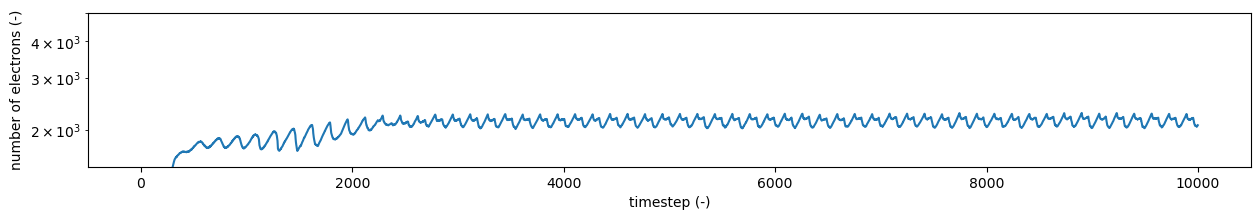

PyObject Text(23.999999999999986, 0.5, 'number of electrons (-)')

In [42]:
using PyPlot
figure(figsize=(15, 2))
semilogy(results.ne)
ylim((1500,5000))
xlabel("timestep (-)")
ylabel("number of electrons (-)")

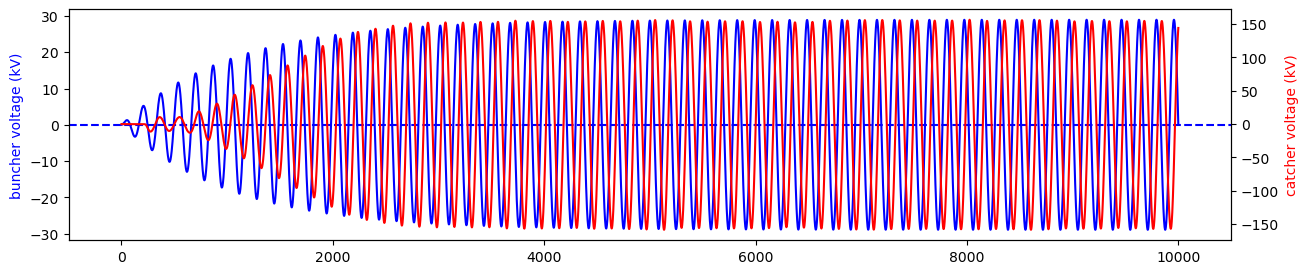

PyObject Text(1284.6805555555557, 0.5, 'catcher voltage (kV)')

In [43]:
using PyPlot
figure(figsize=(15, 3))
axhline(y=0.0, linestyle="--", color="b")
plot(1e-3results.v_ext, "b")
ylabel("buncher voltage (kV)", color="b")
gca().twinx()
plot(1e-3results.v_ind, "r")
xlabel("timestep (-)")
ylabel("catcher voltage (kV)", color="r")

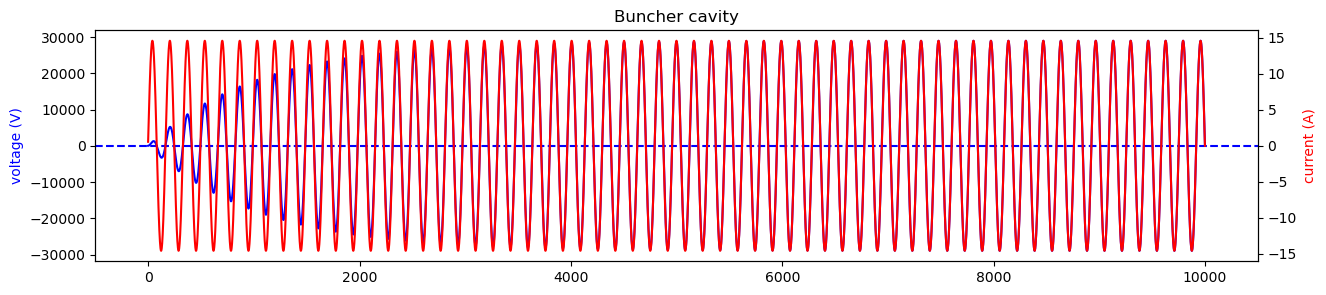

PyObject Text(0.5, 1.0, 'Buncher cavity')

In [44]:
using PyPlot
figure(figsize=(15, 3))
axhline(y=0.0, linestyle="--", color="b")
plot(results.v_ext, "b")
ylabel("voltage (V)", color="b")
gca().twinx()
plot(results.i_ext, "r")
ylabel("current (A)", color="r")
xlabel("timestep (-)")
title("Buncher cavity")

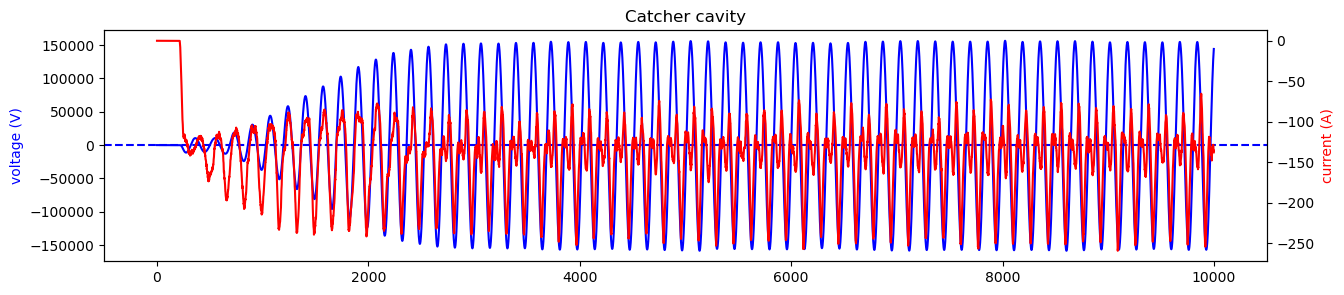

PyObject Text(0.5, 1.0, 'Catcher cavity')

In [45]:
using PyPlot
figure(figsize=(15, 3))
axhline(y=0.0, linestyle="--", color="b")
plot(results.v_ind, "b")
ylabel("voltage (V)", color="b")
gca().twinx()
plot(results.i_ind, "r")
ylabel("current (A)", color="r")
xlabel("timestep (-)")
title("Catcher cavity")

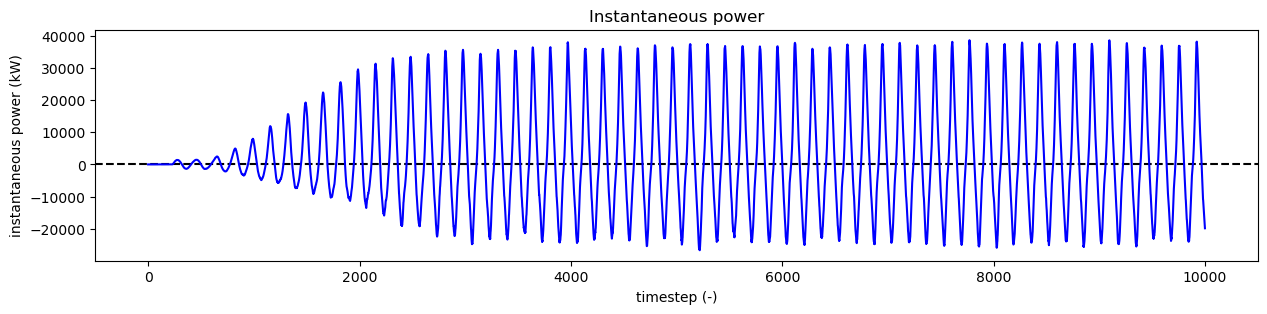

PyObject Text(0.5, 1.0, 'Instantaneous power')

In [46]:
using PyPlot
figure(figsize=(15, 3))
axhline(y=0.0, linestyle="--", color="k")
plot(1e-3 * results.v_ind .* results.i_ind, "b")
xlabel("timestep (-)")
ylabel("instantaneous power (kW)")
title("Instantaneous power")

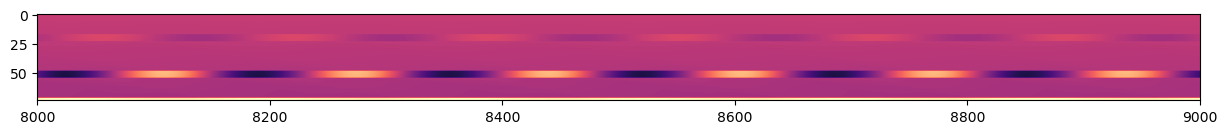

(8000.0, 9000.0)

In [47]:
using PyPlot
figure(figsize=(15, 6))
imshow(results.Ex, cmap="magma")
xlim((8000, 9000))

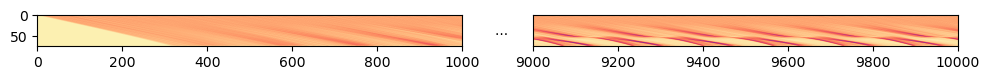

In [48]:
using PyPlot
figure(figsize=(10, 20))
subplot(1,2,1); imshow(results.Jx, cmap="magma"); xlim((0, 1000))
subplot(1,2,2); imshow(results.Jx, cmap="magma"); xlim((9000, 10000)); yticks([]);
ylabel("...            ", rotation="horizontal", verticalalignment="center")
tight_layout()

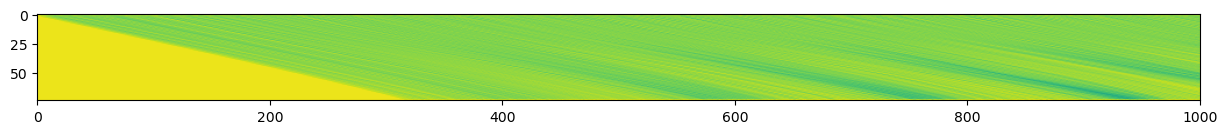

(0.0, 1000.0)

In [49]:
using PyPlot
figure(figsize=(15, 6))
imshow(results.Jx)
xlim((0, 1000))

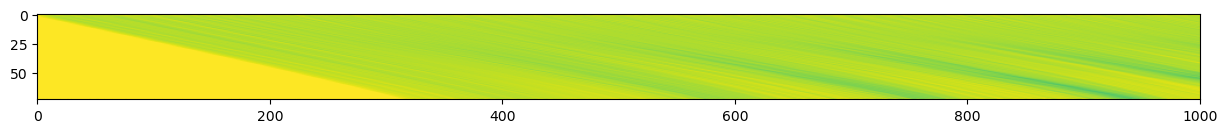

(0.0, 1000.0)

In [50]:
using PyPlot
figure(figsize=(15, 6))
imshow(results.rho)
xlim((0, 1000))

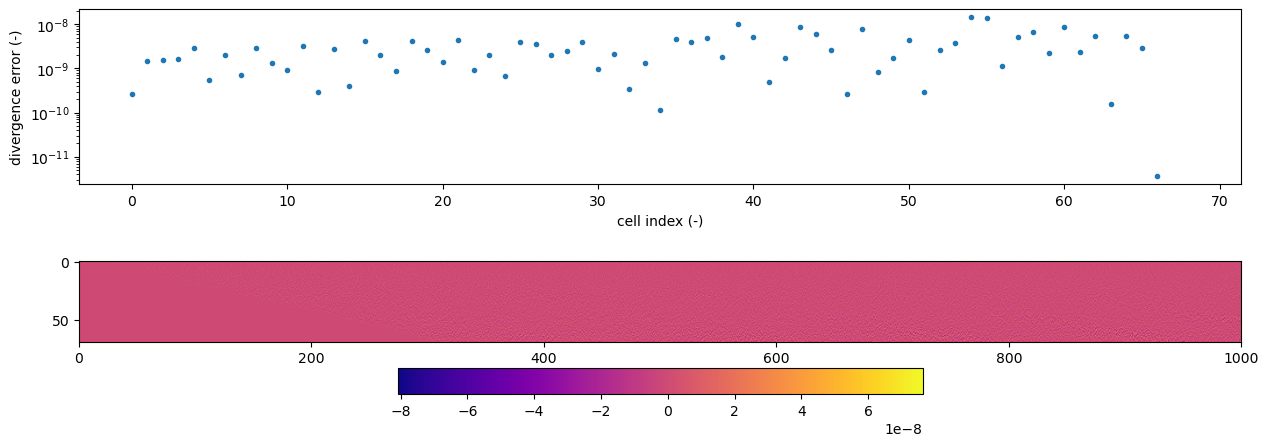

PyObject <matplotlib.colorbar.Colorbar object at 0x14fba4b50>

In [51]:
let
    ts = results.timesteps
    nx = 73
    Δt = 5.0e-12
    Δx = 0.005095890410958904
    
    djx = diff(results.Jx[1:nx+1,1:ts-1]; dims=1)
    drho = diff(results.rho[1:nx,:]; dims=2)
    error = djx ./ Δx .+ drho ./ Δt
    
    figure(figsize=(15, 5))
    subplot(2,1,1)
    semilogy(abs.(error[4:72, 300]), ".")
    xlabel("cell index (-)")
    ylabel("divergence error (-)")
  
    subplot(2,1,2)
    imshow(error[4:72, :], cmap="plasma")
    xlim((0, 1000))
    colorbar(orientation="horizontal")
end

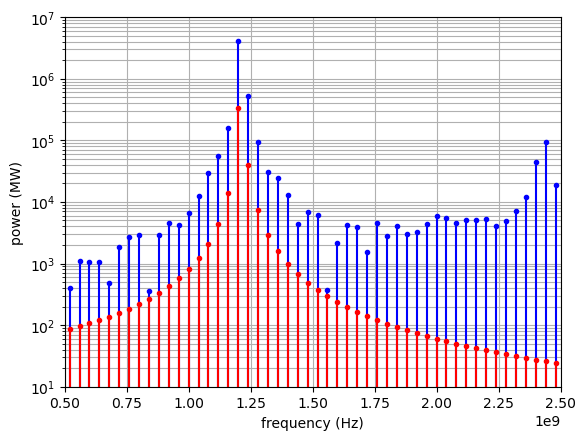

(10.0, 1.0e7)

In [52]:
function showplot(results)
    Δt = 5.0e-12
    window = 5_000:10_000
    samples = length(window)
    frequencies = fftfreq(samples, 1.0 / Δt)
    
    i1 = results.i_ext[window]
    v1 = results.v_ext[window]
    I1 = fft(i1 .- mean(i1))
    V1 = fft(v1 .- mean(v1))
    
    I1 ./= samples
    I1 .*= 2.0
    V1 ./= samples
    V1 .*= 2.0
    
    i2 = results.i_ind[window]
    v2 = results.v_ind[window]
    I2 = fft(i2 .- mean(i2))
    V2 = fft(v2 .- mean(v2))
    
    I2 ./= samples
    I2 .*= 2.0
    V2 ./= samples
    V2 .*= 2.0
    
    stem(frequencies, abs.(I2 .* conj.(V2)), linefmt="b-", markerfmt="b.", basefmt="k--")
    stem(frequencies, abs.(I1 .* conj.(V1)), linefmt="r-", markerfmt="r.", basefmt="k--")
    #plot(frequencies, abs.(I2 .* conj.(V2)), "b.")
    #plot(frequencies, abs.(I1 .* conj.(V1)), "r.")
    xlim((0.5GHz, 2.5GHz))
    xlabel("frequency (Hz)")
    ylabel("power (MW)")
    yscale("log")
    grid(which="both")
    ylim((1e1, 1e7))
end
showplot(results)

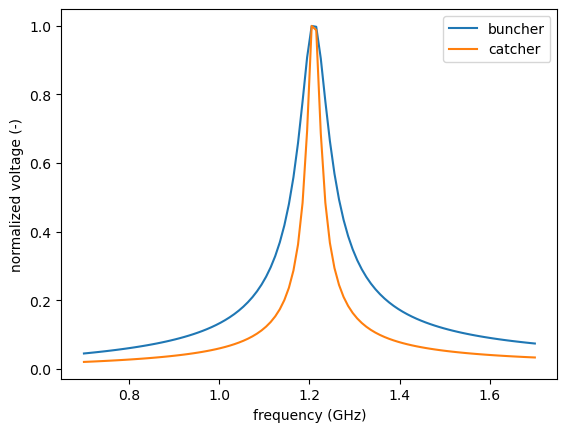

PyObject <matplotlib.legend.Legend object at 0x15f0c2340>

In [53]:
using ACME
let
    Δt = 5.0e-12
    ts = 50_000
    freq = range(0.7GHz, 1.7GHz, length=100)
    outp = similar(freq)

    x = zeros(2, ts)
    t = [Δt * i for i=1:ts]

    for j=1:length(freq)
        model = results.cavity1
        x[1, :] .= [sin(2π * freq[j] * t[i]) for i=1:ts]
        y = run!(model, x)
        outp[j] = abs(maximum(y[ts-1000:ts])) 
    end
    
    plot(1e-9freq, outp ./ maximum(outp))
            
    for j=1:length(freq)
        model = results.cavity2
        x[1, :] .= [sin(2π * freq[j] * t[i]) for i=1:ts]
        y = run!(model, x)
        outp[j] = abs(maximum(y[ts-1000:ts])) 
    end
    
    plot(1e-9freq, outp ./ maximum(outp))
    xlabel("frequency (GHz)")
    ylabel("normalized voltage (-)")
    legend(("buncher", "catcher"))
end

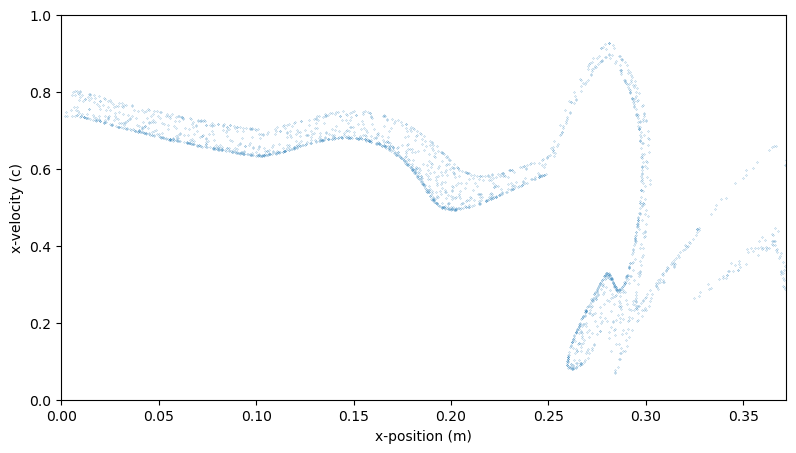

PyObject Text(24.0, 0.5, 'x-velocity (c)')

In [54]:
let
    Δt = 5.0e-12
    Δx = 0.005095890410958904
    e, = final.particles
    
    figure(figsize=(9.35, 5))
    axhline(y = (Δx / Δt) / c0, color="k")
    scatter([e.x[p] for p in 1:e.np], [e.v[p][1] / c0 for p in 1:e.np], marker=".", s=0.1)
    ylim((0.0, 1.0))
    xlim((0.0, 0.372))
    xlabel("x-position (m)")
    ylabel("x-velocity (c)")
end

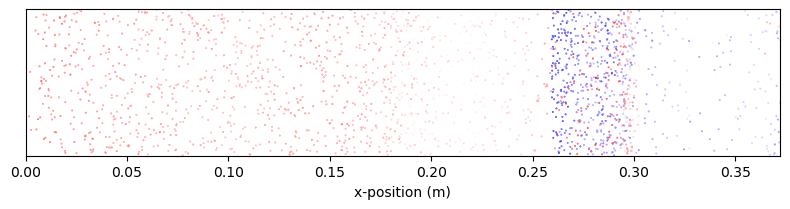

PyObject Text(19.944444444444443, 0.5, '')

In [55]:
let
    e, = final.particles
    
    figure(figsize=(8, 2))
    scatter([e.x[p] for p in 1:e.np], [rand() for p in 1:e.np],
        c=[e.v[p][1] / c0 for p in 1:e.np],
        s=0.5, marker=".", cmap="bwr")
    ylim((0.0, 1.0))
    xlim((0.0, 0.372))
    yticks([])
    tight_layout()
    #colorbar(orientation="horizontal")
    xlabel("x-position (m)")
    ylabel("")
end

In [ ]:
using ProgressMeter

function sweep()
    println("[*] Sweeping I0")
    n  = 40
    
    I0 = range(2kA, 12kA, length=n)
    U0 = 150kV
    I1 = 10A
    Pmax = zeros(n)
    
    @showprogress for k = 1:n
        state, context = build(I0[k], U0, I1)
        pusher = context.pusher
        solver = context.solver
        steps  = context.timesteps
        grid   = context.grid

        solve(state, pusher, solver, grid, [], steps, context)
        Pmax[k] = evaluate(context)
    end
    
    return I0, Pmax
end
x, y = sweep();

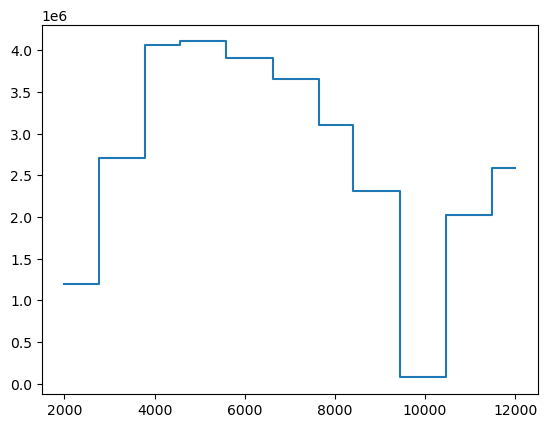

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2a4aeaee0>

In [27]:
step(x, y)

In [ ]:
using ProgressMeter

function sweep()
    println("[*] Sweeping I1")
    n  = 50
    
    I0 = 7kA
    U0 = 150kV
    I1 = range(1A, 10A, length=n)
    Pmax = zeros(n)
    
    @showprogress for k = 1:n
        state, context = build(I0, U0, I1[k])
        pusher = context.pusher
        solver = context.solver
        steps  = context.timesteps
        grid   = context.grid

        solve(state, pusher, solver, grid, [], steps, context)
        Pmax[k] = evaluate(context)
    end
    
    return I1, Pmax
end
x, y = sweep();

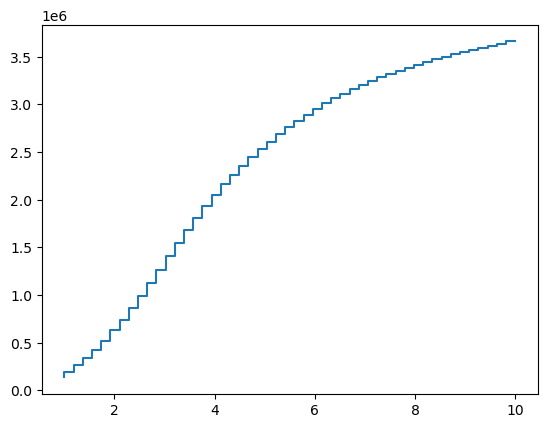

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2a4a25070>

In [29]:
step(x, y)

In [ ]:
function sweep()
    println("[*] Sweeping U0")
    n  = 50
       
    I0 = 7kA
    U0 = range(50kV, 200kV, length=n)
    I1 = 10A
    Pmax = zeros(n)
    
    @showprogress for k = 1:n
        state, context = build(I0, U0[k], I1)
        pusher = context.pusher
        solver = context.solver
        steps  = context.timesteps
        grid   = context.grid

        solve(state, pusher, solver, grid, [], steps, context)
        Pmax[k] = evaluate(context)
    end
    
    return U0, Pmax
end

x, y = sweep();

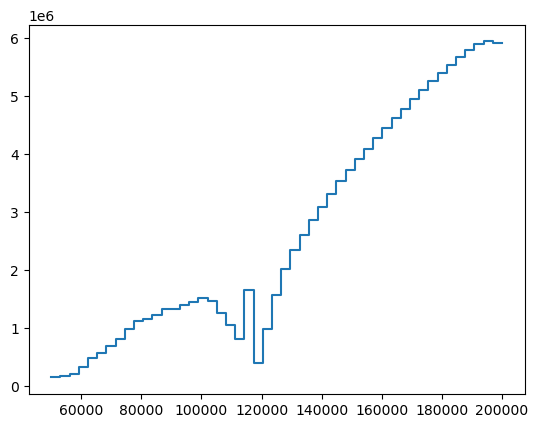

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2a49c85e0>

In [31]:
step(x, y)